In [1]:
import numpy
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# $f(x,y)=cos(x)+sin(y)$

In [2]:
def f(x, y):
    return torch.cos(x)+torch.sin(y)

# Preprocessing part

In [3]:
y_steps, x_steps = 4, 4
y_start, y_end = -10, 10
x_start, x_end = -10, 10

In [4]:
rectangle = torch.tensor([[x_start, y_start]]) + torch.tensor([
[0, 0],
[1, 0],
[1, 1],
[0, 1]
]) * torch.tensor([[(x_end-x_start)/x_steps, (y_end-y_start)/y_steps]])
h_1 = (x_end - x_start)/x_steps
h_2 = (y_end - y_start)/y_steps

In [5]:
rectangles = []
for stepy in range(y_steps):
    for stepx in range(x_steps):
        
        shift = torch.tensor([(x_end - x_start)/x_steps*stepx , 
                              (y_end - y_start)/y_steps*stepy])
        rectangles.append(rectangle + shift)
        
rectangles_s = torch.stack(rectangles)
rectangles_c = torch.cat(rectangles)

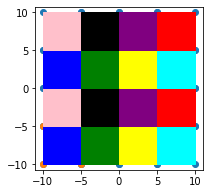

In [6]:
colors = ['red', 'blue', 'green', 'yellow', 'cyan', 'pink', 'black', 'purple']
l = len(colors)

fig, ax = plt.subplots(figsize=(3, 3))
ax.axis('equal')

ax.scatter(rectangles_c[:, 0], rectangles_c[:, 1])
ax.scatter(rectangles_s[0, :, 0], rectangles_s[0, :, 1])

for index, rectangle in enumerate(rectangles_s, 1):
    t1 = plt.Polygon(rectangle, color=colors[index%l])
    plt.gca().add_patch(t1)
plt.show()

In [7]:
y_steps, x_steps = 5, 5
y_start, y_end = -10, 10
x_start, x_end = -10, 10

In [8]:
X = torch.linspace(x_start, x_end, x_steps)
Y = torch.linspace(y_start, y_end, y_steps)

In [9]:
tx = torch.linspace(-10, 10, 50)
ty = torch.linspace(-10, 10, 50)
xx, yy = torch.meshgrid(tx, ty, indexing='xy')
points = torch.stack((xx, yy)).permute(1, 2, 0)

In [10]:
x_index = torch.where((points[:, :, 0][..., None] >= X[:-1]) & (points[:, :, 0][..., None] <= X[1: ]))
y_index = torch.where((points[:, :, 1][..., None] >= Y[:-1]) & (points[:, :, 1][..., None] <= Y[1: ]))
h_1 = X.diff()[0]
h_2 = Y.diff()[0]

In [11]:
zz = torch.zeros(xx.shape)

In [12]:
zz[x_index[:-1]] = (\
((X[x_index[-1]+1] - xx[x_index[:-1]])* (Y[y_index[-1]+1]-yy[y_index[:-1]])) * f(X[x_index[-1]], Y[y_index[-1]]) + \
(xx[x_index[:-1]] - X[x_index[-1]])* (Y[y_index[-1]+1]-yy[y_index[:-1]]) * f(X[x_index[-1]+1], Y[y_index[-1]]) + \
(X[x_index[-1]+1] - xx[x_index[:-1]])* (yy[y_index[:-1]]-Y[y_index[-1]]) * f(X[x_index[-1]], Y[y_index[-1]+1])+ \
(xx[x_index[:-1]] - X[x_index[-1]])* (yy[y_index[:-1]]-Y[y_index[-1]]) * f(X[x_index[-1]+1], Y[y_index[-1]+1])
)/h_1/h_2

# $C^{0}$ linear interpolation

$$p_1^{(i,j)} = \frac{1}{h_1h_2}(x_{i+1}-x)(y_{i+1}-y)f_{i,j} + \frac{1}{h_1h_2}(x-x_i)(y_{i+1}-y)f_{i+1,j}+\frac{1}{h_1h_2}(x_{i+1}-x)(y-y_i)f_{i,j+1}+\frac{1}{h_1h_2}(x-x_i)(y-y_i)f_{i+1,j+1}$$ 

In [13]:
XX, YY = torch.meshgrid(X, Y, indexing='xy')

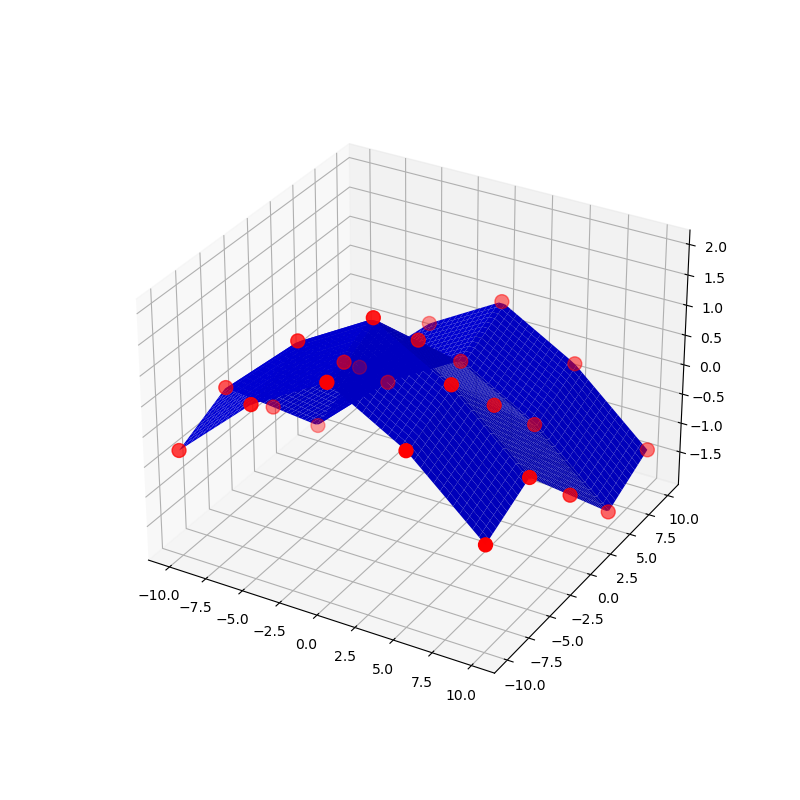

In [14]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, zz, color='blue')
ax.scatter(XX, YY, f(XX, YY), color='red', s=100)

# Interpolating with basis functions

In [15]:
y_steps, x_steps = 5, 20
y_start, y_end = -10, 10
x_start, x_end = -10, 10

In [16]:
X = torch.linspace(x_start, x_end, x_steps)
Y = torch.linspace(y_start, y_end, y_steps)
h_1 = X.diff()[0]
h_2 = Y.diff()[0]

In [17]:
def phi(X, Y, h1, h2, i, j, n_x, n_y):
    
    tx = torch.linspace(X.min(), X.max(), n_x)
    ty = torch.linspace(Y.min(), Y.max(), n_y)
    
    xx, yy = torch.meshgrid(tx, ty, indexing='xy')
    xx = (xx - xx.min())
    yy = (yy - yy.min())
    
    tmp = torch.zeros(xx.shape)
        
    idx1 = (i - 1 <= xx/h1) & (xx/h1 <= i) & (j - 1 <= yy/h2) & (yy/h2 <= j)
    tmp[idx1] = ((xx/h1-i+1)*(yy/h2-j+1))[idx1]
    
    idx2 = (i - 1 <= xx/h1) & (xx/h1 <= i) & (j <= yy/h2) & (yy/h2 <= j + 1)
    tmp[idx2] = ((xx/h1-i+1)*(j+1-yy/h2))[idx2]
    
    idx3 = (i <= xx/h1) & (xx/h1 <= i + 1) & (j - 1 <= yy/h2) & (yy/h2 <= j)
    tmp[idx3] = ((i+1-xx/h1)*(yy/h2-j+1))[idx3]
    
    idx4 = (i <= xx/h1) & (xx/h1 <= i + 1) & (j <= yy/h2) & (yy/h2 <= j + 1)
    tmp[idx4] = ((i+1-xx/h1)*(j+1-yy/h2))[idx4]
    
    return tmp

In [18]:
n_x, n_y = 50, 50
tx = torch.linspace(-10, 10, n_x)
ty = torch.linspace(-10, 10, n_y)
xx, yy = torch.meshgrid(tx, ty, indexing='xy')
zz = torch.zeros(n_y, n_x)

for i in range(x_steps):
    for j in range(y_steps):
        zz += phi(X, Y, h_1, h_2, i, j, n_x, n_y)*f(X[i], Y[j])

In [19]:
XX, YY = torch.meshgrid(X, Y, indexing='xy')

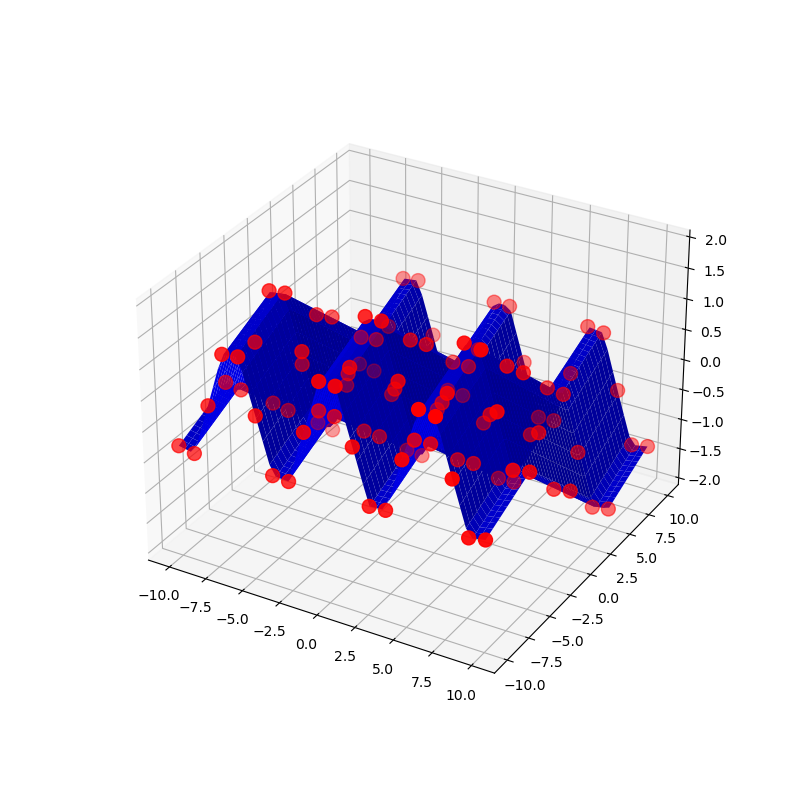

In [20]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, zz, color='blue')
ax.scatter(XX, YY, f(XX, YY), color='red', s=100)

# Single basis
$$\phi_{i,j}(x,y)=
\begin{cases}
\left[\frac{x}{h}-(i-1)\right]\left[\frac{y}{h}-(j-1)\right] \\
\left[\frac{x}{h}-(i-1)\right]\left[(j+1)-\frac{y}{h}\right] \\
\left[(i+1)-\frac{x}{h}\right]\left[\frac{y}{h}-(j-1)\right] \\
\left[(i+1)-\frac{x}{h}\right]\left[(j+1)-\frac{y}{h}\right]
\end{cases} 
$$

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, phi(X, Y, h_1, h_2, 2, 2, n_x, n_y), cmap='magma')
plt.show()

# Single rectangular element

In [ ]:
X = torch.tensor([0, 1])
Y = torch.tensor([0, 1])
t = torch.linspace(0, 1, 10)
xx, yy = torch.meshgrid(t, t, indexing='xy')

In [ ]:
alpha = (X[1]-xx)*(Y[1]-yy)
betta = (xx-X[0])*(Y[1]-yy)
gamma = (X[1]-xx)*(yy-Y[0])
delta = (xx-X[0])*(yy-Y[0])

In [ ]:
zz = \
alpha *2 + \
betta *-1 + \
gamma *-1 + \
delta *2

In [ ]:
XX, YY = torch.meshgrid(X, Y, indexing='xy')

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, zz, color='green')
ax.scatter(XX, YY, [2, -1, -1, 2], color='red', s=100)

# Hermite interpolation basis functions

In [2]:
import numpy as np

In [3]:
def phi_0(t, t_0, h, t_N, j):
        
    F = np.zeros_like(t)
    
    f1 = (1+(t-t_0)/h-j)**2 * (1-2*(t-t_0)/h+2*j)
    f2 = (1-(t-t_0)/h+j)**2 * (1+2*(t-t_0)/h-2*j)
        
    F[(-1+j<=(t-t_0)/h)&((t-t_0)/h<=0+j)] = f1[(-1+j<=(t-t_0)/h)&((t-t_0)/h<=0+j)]
    F[(+0+j<=(t-t_0)/h)&((t-t_0)/h<=1+j)] = f2[(+0+j<=(t-t_0)/h)&((t-t_0)/h<=1+j)]
    
    return F

In [4]:
def phi_1(t, t_0, h, t_N, j):
    
    F = np.zeros_like(t)
    
    f1 = (1-(t-t_0)/h+j)**2 * ((t-t_0)/h-j)
    f2 = (1+(t-t_0)/h-j)**2 * ((t-t_0)/h-j)
    
    F[(+0+j<=(t-t_0)/h)&((t-t_0)/h<=1+j)] = f1[(+0+j<=(t-t_0)/h)&((t-t_0)/h<=1+j)]
    F[(-1+j<=(t-t_0)/h)&((t-t_0)/h<=0+j)] = f2[(-1+j<=(t-t_0)/h)&((t-t_0)/h<=0+j)]
    
    return F

In [5]:
x, y = np.linspace(-2, 2, 1000), np.linspace(-2, 2, 1000)
(X, h1), (Y, h2) = np.linspace(-2, 2, 5, retstep=True), np.linspace(-2, 2, 5, retstep=True)
xx, yy = np.meshgrid(x, y, indexing='ij')

In [6]:
# XX, YY = np.meshgrid(X, Y, indexing='ij')
# ZZ = 1 / (1+ XX**2+YY**2)

# zz = np.zeros_like(xx)

# for i in range(10):
#     for j in range(10):
#         zz += ZZ[i][j] * np.outer(phi_0(x, X[0], h1, X[-1], j), phi_0(y, Y[0], h2, Y[-1], i))
#         zz += ZZ[i][j] * np.outer(phi_1(x, X[0], h1, X[-1], j), phi_1(y, Y[0], h2, Y[-1], i))

In [7]:
YYY_1 = np.outer(phi_0(x, X[0], h1, X[-1], 2), phi_0(y, Y[0], h2, Y[-1], 2))
YYY_2 = np.outer(phi_0(x, X[0], h1, X[-1], 2), phi_1(y, Y[0], h2, Y[-1], 2))
YYY_3 = np.outer(phi_1(x, X[0], h1, X[-1], 2), phi_0(y, Y[0], h2, Y[-1], 2))
YYY_4 = np.outer(phi_1(x, X[0], h1, X[-1], 2), phi_1(y, Y[0], h2, Y[-1], 2))

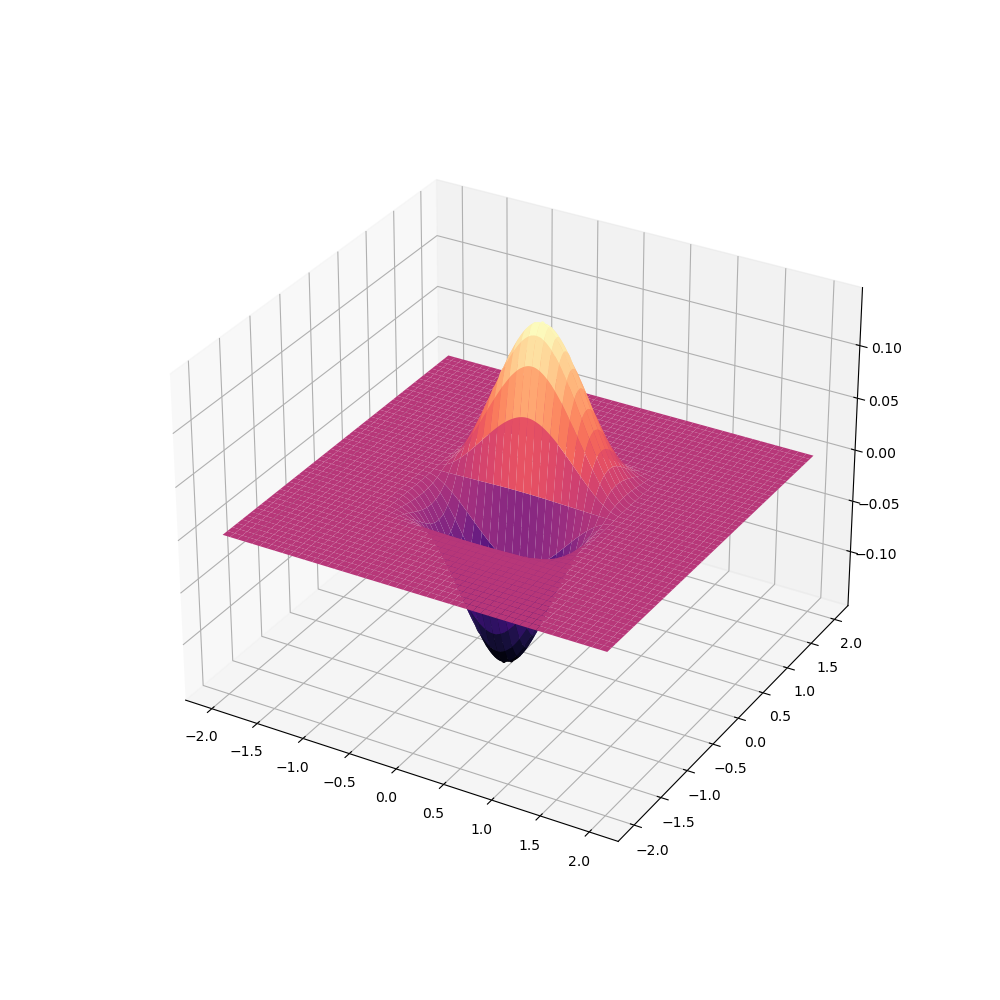

In [12]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, YYY_2, cmap='magma')
# fig.savefig('../images/two_dimensional_ermite_4')
plt.show()